In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
from queue_function import run_queue_experiment
from util import initialize_parallel_rngs

In [3]:
data = run_queue_experiment(rng=initialize_parallel_rngs(1, 9523)[0],
                            time=20000, arrival_rate=0.9, capacity_server=1)
print(np.mean(data.wait_times))
print(np.mean(data.n_queue))

9.581496027442084
8.709777950915466


In [4]:
#plot that shows how the mean wait time changes for multiple time intervals (so we can decide on the appropriate time)

17969
17969


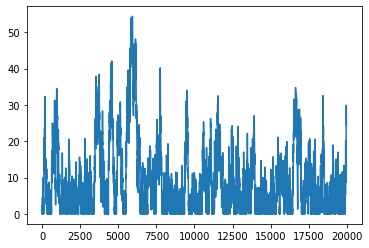

In [5]:
print(len(data.times))
print(len(data.wait_times))
#print(data.wait_times)
plt.plot(data.times, data.wait_times)
#plt.plot(data.times, data.n_queue)
#plt.hist(data.wait_times)
plt.show()

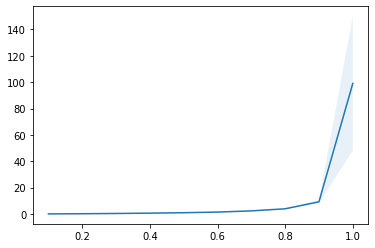

In [6]:
def vary_rho():
    capacity_server = 1
    n_runs = 10
    rhos = np.linspace(0.1 ,1, 10)
    run_data = []
    rngs = initialize_parallel_rngs(len(rhos), 89191)
    for run in range(n_runs):
        rho_data = []
        for i, rho in enumerate(rhos):
            data = run_queue_experiment(rng=rngs[i], time=20000, arrival_rate=rho*capacity_server,
                                        capacity_server=capacity_server)
            rho_data.append(np.mean(data.wait_times))
        run_data.append(rho_data)
    run_data = np.array(run_data)
    return run_data, rhos

run_data, rhos = vary_rho()
run_data_mean = np.mean(run_data, axis=0)
run_data_std = np.std(run_data, axis=0, ddof=1)
plt.plot(rhos, run_data_mean)
plt.fill_between(rhos, run_data_mean - run_data_std, run_data_mean + run_data_std, alpha=0.1)
plt.show()

In [24]:
import multiprocessing as mp
import queue
from queue_function import vary_t_worker

def vary_t(min_exp, max_exp, seed, arrival_rate, capacity_server, n_server=1, steps=10, n_runs=5):
    manager = mp.Manager()
    results = manager.list()
    t_range = np.logspace(min_exp, max_exp, num=((max_exp - min_exp) + 1)*steps, dtype=int)
    
    work_queue = mp.Queue()
    for i in range(n_runs):
        results.append(manager.list())
        for t in t_range:
            work_queue.put((t, i))
    
    rngs = initialize_parallel_rngs(mp.cpu_count(), seed)
    processes = []

    for i in range(mp.cpu_count()):
        p = mp.Process(target=vary_t_worker, args=(
            work_queue, results, rngs[i], arrival_rate, capacity_server, n_server
        ))
        p.daemon = True
        p.start()
        processes.append(p)

    for p in processes:
        p.join()

    return  [list(t) for t in results], t_range

In [29]:
vary_t_results, t_range = vary_t(min_exp=3, max_exp=4, seed=8539, arrival_rate=0.8, capacity_server=1,
                                 n_runs=5, steps=5)

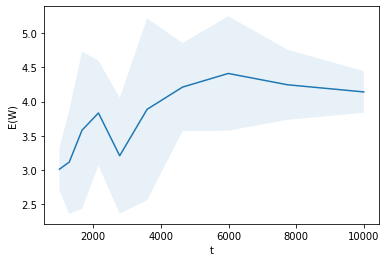

In [30]:
results = [list(t) for t in vary_t_results]
results_means = np.mean(results, axis=0)
results_std = np.std(results, axis=0, ddof=1)
plt.plot(t_range, results_means)
plt.fill_between(t_range, results_means - results_std, results_means + results_std, alpha=0.1)
plt.xlabel("t")
plt.ylabel("E(W)")
plt.show()